### Setup

In [1]:
from __future__ import print_function

import re
import numpy as np
from numpy import random
import csv
import shutil
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import logging
import sys
import os
from os import path
from optparse import OptionParser
from time import time
from tqdm import tqdm_notebook
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE

### Dataset

In [3]:
with open('../../Datasets/product-item-data.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    for i, row in enumerate(lines):
        rowSplit = row[1].split(' - ',1)
        name = rowSplit[0]
        # remove markdown tags
        description = re.sub('<.*>', '', rowSplit[1])
        newRow = [name, description]
        lines[i] = newRow

with open('../../Datasets/product-item-data_P.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerow(['name','description'])
    writer.writerows(lines)

readFile.close()
writeFile.close()

In [4]:
dataset = pd.read_csv('../../Datasets/product-item-data_P.csv')
dataset.head(5)

,name,description
0,Active classic boxers,There's a reason why our boxers are a cult fav...
1,Active sport boxer briefs,Skinning up Glory requires enough movement wit...
2,Active sport briefs,These superbreathable no-fly briefs are the mi...
3,Alpine guide pants,"Skin in, climb ice, switch to rock, traverse a..."
4,Alpine wind jkt,"On high ridges, steep ice and anything alpine,..."


In [5]:
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(dataset.description)
print(vectors.shape)

print(vectors.nnz)
nnz_sample = vectors.nnz / float(vectors.shape[0])
nnz_perc   = 100 * (nnz_sample /  float(vectors.shape[1]))
print("Non Zero per Sample: ", nnz_sample)
print("Non Zero per Sample Percentage: ", round(nnz_perc, 2), "%")

(500, 4098)
26152
Non Zero per Sample:  52.304
Non Zero per Sample Percentage:  1.28 %


In [6]:
feat_names = vectorizer.get_feature_names()
stop_words = vectorizer.get_stop_words()

In [7]:
bigram_vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)
bi_vectors = bigram_vectorizer.fit_transform(dataset.description)
print(bi_vectors.shape)
print(bi_vectors.nnz)
bi_nnz_sample = bi_vectors.nnz / float(vectors.shape[0])
bi_nnz_perc   = 100 * (bi_nnz_sample /  float(bi_vectors.shape[1]))
print("Non Zero per Sample: ", bi_nnz_sample)
print("Non Zero per Sample Percentage: ", round(bi_nnz_perc, 2), "%")

(500, 23324)
81326
Non Zero per Sample:  162.652
Non Zero per Sample Percentage:  0.7 %


In [8]:
bi_feat_names = bigram_vectorizer.get_feature_names()
bi_stop_words = bigram_vectorizer.get_stop_words()

### Cluster Documents 

In [9]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.


In [10]:
print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(dataset.description)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

Extracting features from the training dataset using a sparse vectorizer
done in 0.065049s
n_samples: 500, n_features: 2267



In [11]:
true_k = 10

if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=100, batch_size=100, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
labels = km.fit_predict(X)
print("done in %0.3fs" % (time() - t0))

#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
#print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
#print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_, sample_size=100))

if not opts.use_hashing:
    print("\nTop terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("\nCluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')

Clustering sparse data with MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=100, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=False)
done in 0.108s
Silhouette Coefficient: 0.021

Top terms per cluster:

Cluster 0: insole shank wading padded strap mesh foot extra light support
Cluster 1: ringspun shirt printed organic taped cotton phthalate inks pvc usa
Cluster 2: shorts inseam pockets size nylon vietnam water stretch crotch 40
Cluster 3: polyester water nylon merino zippered spandex soft durable pockets breathable
Cluster 4: denier pocket polyurethane strap water mesh coating zippered shoulder compartment
Cluster 5: control gladiodor natural odor garment capilene beneath fastest layers wicking
Cluster 6: thailand organic cotton 32 button size long inseam short pockets
Cluster 7: waders 84 16 fabric rashguard sizzling underarm gussets sleeved version
Clu

In [12]:
with open('../../Datasets/product-item-data_P.csv', 'r') as readFile:
    reader = csv.reader(readFile)
    lines = list(reader)
    for i, row in enumerate(lines[1:]):
        newRow = [labels[i], row[0], row[1]]
        lines[i] = newRow

with open('../../Datasets/product-item-data_L.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerow(['label', 'name', 'description'])
    writer.writerows(lines)

readFile.close()
writeFile.close()

#### Top Terms for the entire Dataset

Here we can find some "stop_word" in the dataset

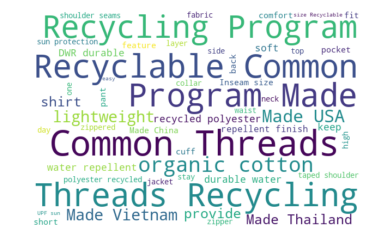

In [13]:
text = " ".join(description for description in dataset.description)
    
# Create and generate a word cloud image:
wordcloud = WordCloud(width=600, height=400, max_words=50, background_color="white", repeat=False).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Cluster Centroids Shape:  (10, 2267)
Cluster Transformed Centroids Shape:  (10, 2)


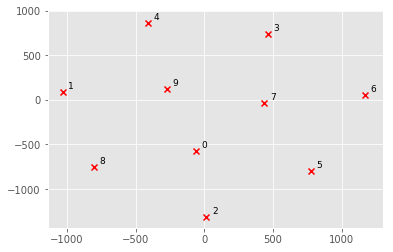

In [14]:
tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1
model = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
             early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

transformed_centroids = model.fit_transform(km.cluster_centers_)
print("Cluster Centroids Shape: ", km.cluster_centers_.shape)
print("Cluster Transformed Centroids Shape: ", transformed_centroids.shape)
#plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], marker='x')
for i, centroid in enumerate(transformed_centroids):
    x = centroid[0]
    y = centroid[1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+40, y+40, i, fontsize=9)
plt.show()

Cluster Centroids Shape:  (10, 2267)
Cluster Transformed Centroids Shape:  (10, 2)


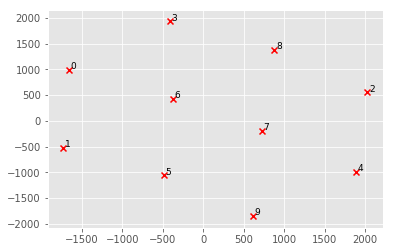

In [15]:
tsne_init = 'random'  # could also be 'random'
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1
model = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
             early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

transformed_centroids = model.fit_transform(km.cluster_centers_)
print("Cluster Centroids Shape: ", km.cluster_centers_.shape)
print("Cluster Transformed Centroids Shape: ", transformed_centroids.shape)
for i, centroid in enumerate(transformed_centroids):
    x = centroid[0]
    y = centroid[1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+20, y+20, i, fontsize=9)
plt.show()

Plotting Cluster  0  Number of Itens:  7
Plotting Cluster  1  Number of Itens:  63
Plotting Cluster  2  Number of Itens:  26
Plotting Cluster  3  Number of Itens:  216
Plotting Cluster  4  Number of Itens:  26
Plotting Cluster  5  Number of Itens:  22
Plotting Cluster  6  Number of Itens:  97
Plotting Cluster  7  Number of Itens:  13
Plotting Cluster  8  Number of Itens:  12
Plotting Cluster  9  Number of Itens:  18


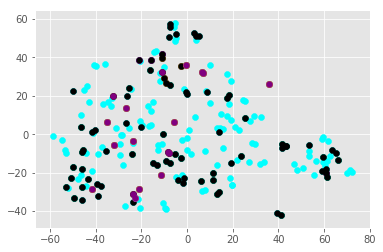

In [16]:
tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1
model = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
             early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

arrayX = X.toarray()

transformed_all = model.fit_transform(arrayX)
count = np.zeros(10, dtype=int)
dataByLabel = [[]]*10
transfDataByLabel = []*10
for i, label in enumerate(labels):
    count[label] +=1
    dataByLabel[label].append(transformed_all[i])
dataByLabel = np.array(dataByLabel)

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple']

for i, centroid in enumerate(transformed_centroids):
    print("Plotting Cluster ", i, " Number of Itens: ", count[i])
    transfDataByLabel.append(dataByLabel[i])
    plt.scatter(transfDataByLabel[i][:count[i],0], 
                transfDataByLabel[i][:count[i],1], 
                marker='o', color=colors[i])

#plt.gca().set_xbound(-1700, 1700)
#plt.gca().set_ybound(-1500, 1700)
#plt.gcf().set_size_inches(20, 20)
# plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()